### Simulation: `M2e3_R3_S0_T1_B0.01_Res126_n2_sol0.5_42`  
* label: `sim_1`  
* Fiducial STARFORGE simulation (low mass-resolution version).
* Initial molecular cloud mass: $2000$ solar masses (mass resolution: $\Delta m = 2 \times 10^{-3} \, M_{\odot}$; $2\times10^5$ finite-mass gas particles evolved simulation).  
* Initial cloud radius: 3 parsecs.  
* Output: 751 HDF5 snapshot files (time between snapshots = 1.31186e-05 code_time = 0.0128 Myr). 

### Files:
**sink_system_labels.hdf5:** Labels the stellar multiplicity of each sink particle ("star") in each of the 751 simulation snapshots
* `dataset /sink_IDs`: unique integer IDs for each sink (star) particle formed in simulation; 212  sink particles total.  
* `dataset /labels`  : sink particle multiplicity for each snapshot file in the simulation (`0 = not yet formed`, `1 = single`, `2 = binary`, `3 = triple`, `4 = quadruple system`)  

**all_accreted_gas_properties.hdf5:** Contains various gas properties (mass, velocity dispersion, etc.) describing the gas that will eventually accrete onto the sink particle for each sink particle formed in the simulation.  
* `dataset /sink_X` (X = unique sink ID): properties of gas associated with sink particle X.

In [1]:
import numpy as np
import sys
import os
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt

In [8]:
datadir = '/home/naf999/jupyter-workspace/binary_gas/sample_data/'
figdir  = '/home/naf999/jupyter-workspace/binary_gas/figures/'

fname_1 = os.path.join(datadir, 'sim_1_sink_system_labels.hdf5')
fname_2 = os.path.join(datadir, 'sim_1_all_accreted_gas_properties.hdf5')

In [3]:
# Unit conversions (code_units to cgs).
m_unit = 1.989e33                                 # [g]
l_unit = 3.086e18                                 # [cm]
v_unit = 100.0                                    # [cm/s]
t_unit = l_unit / v_unit                          # [s]
B_unit = 1e4                                      # [Gauss]
t_unit_myr = t_unit / (3600. * 24. * 365. * 1e6)  # [Myr]
E_unit = m_unit * v_unit**2                       # [erg = g cm^2 s^-2]
L_unit = m_unit * v_unit * l_unit                 # [m cm^2 s^-1]

In [4]:
# Get all sink IDs and multiplicity labels.
with h5py.File(fname_1, 'r') as f:
    sink_IDs = f['sink_IDs'][()]  # shape: (num_sink_particles)
    labels   = f['labels'][()]    # shape: (num_snapshots, num_sink_particles)

In [9]:
# Get accreted gas properties data for each sink particle.
num_sinks      = len(sink_IDs)
sink_data_dict = dict.fromkeys(sink_IDs.astype(np.int64))

with h5py.File(fname_2, 'r') as f:
    for sink_ID in sink_IDs:
        sink_label = 'sink_{0:d}'.format(sink_ID)
        sink_data_dict[sink_ID] = f[sink_label][()]

In [15]:
def make_fig(sink_ID, sink_data_dict=sink_data_dict, savefig=False, xmax=3.5):

    data    = sink_data_dict[sink_ID]
    t       = data[:, 25]                         # Current time.
    M_tot   = data[:, 0]                          # Total mass (of gas not yet accreted onto star)
    X_cm    = data[:, 1:4]                        # Center-of-mass position.
    V_cm    = data[:, 4:7]                        # Center-of-mass velocity.
    L_vec   = data[:, 7:10]                       # Total angular momentum vector.
    L_mag   = np.sqrt(np.sum(L_vec**2, axis=1))   # Angular momentum magnitude.
    R_eff   = data[:, 10]                         # Effective radius.
    R_p     = data[:, 11:14]                      # Aspect ratio shape parameters.
    T       = data[:, 14]                         # Average temperature.
    B       = data[:, 15]                         # Average magnetic field magnitude.
    Ne      = data[:, 16]                         # Average electron abundance.
    sig3D   = data[:, 17]                         # 3D velocity dispersion.
    E_grav  = data[:, 18]                         # Gravitational potential energy.
    E_kin   = data[:, 19]                         # Kinetic energy.
    E_mag   = data[:, 20]                         # Magnetic energy.
    E_int   = data[:, 21]                         # Internal/thermal energy.

    aspect_ratio = np.max(R_p, axis=1)/np.min(R_p, axis=1)

    r_cm     = np.sqrt(np.sum(X_cm**2, axis=1))
    v_cm_mag = np.sqrt(np.sum(V_cm**2, axis=1))
    
    fs=12

    fig, axs = plt.subplots(3, 4, figsize=(14, 8), sharex=True)

    axs[0][0].plot(t * t_unit_myr, M_tot, lw=2, c='tab:blue')
    axs[0][0].set_ylabel(r'$M_{\rm tot}$ [$M_{\odot}$]', fontsize=fs)
    axs[1][0].plot(t * t_unit_myr, R_eff, lw=2)
    axs[1][0].set_ylabel(r'$R_{\rm eff}$ [pc]', fontsize=fs)
    axs[2][0].plot(t * t_unit_myr, aspect_ratio, lw=2)
    axs[2][0].set_ylabel(r'aspect ratio', fontsize=fs)
    axs[2][0].set_ylim(ymin=1, ymax=5)
    axs[2][0].set_xlabel(r'$t$ [Myr]', fontsize=fs)
    
    axs[0][1].plot(t * t_unit_myr, sig3D, lw=2)
    axs[0][1].set_ylabel(r'$\sigma_{3D}$ [m/s]', fontsize=fs)
    axs[1][1].plot(t * t_unit_myr, v_cm_mag, lw=2)
    axs[1][1].set_ylabel(r'$|v_{\rm cm}|$ [m/s]', fontsize=fs)
    axs[2][1].plot(t * t_unit_myr, L_mag*L_unit, lw=2)
    axs[2][1].set_ylabel(r'$|L|$ [g cm$^2$ s$^{-1}$]', fontsize=fs)
    axs[2][1].set_xlabel(r'$t$ [Myr]', fontsize=fs)

    axs[0][2].plot(t * t_unit_myr, np.abs(E_grav)*E_unit, lw=2, c='tab:blue', label=r'$|E_{\rm grav}|$')
    axs[0][2].plot(t * t_unit_myr, E_kin*E_unit, lw=2, c='tab:red', label=r'$E_{\rm kin}$')
    axs[0][2].plot(t * t_unit_myr, E_mag*E_unit, lw=2, c='tab:green', label=r'$E_{\rm mag}$')
    axs[0][2].plot(t * t_unit_myr, E_int*E_unit, lw=2, c='tab:orange', label=r'$E_{\rm int}$')
    axs[0][2].set_yscale('log')
    axs[0][2].legend(loc='lower left', fontsize=9)
    axs[0][2].set_ylabel(r'energy [erg]', fontsize=fs)
    axs[1][2].plot(t * t_unit_myr, (2.0*E_kin)/np.abs(E_grav), lw=2, c='tab:blue')
    axs[1][2].set_ylabel(r'$2E_{\rm kin}/|E_{\rm grav}|$', fontsize=fs)
    axs[1][2].set_ylim(ymin=1.0, ymax=1e4)
    axs[1][2].set_yscale('log')
    axs[2][2].plot(t * t_unit_myr, E_mag/E_kin, lw=2, c='tab:blue')
    axs[2][2].set_ylabel(r'$E_{\rm mag}/E_{\rm kin}$', fontsize=fs)
    axs[2][2].set_ylim(ymin=0.0, ymax=5.0)
    axs[2][2].set_xlabel(r'$t$ [Myr]', fontsize=fs)
    
    axs[0][3].plot(t * t_unit_myr, T, lw=2)
    axs[0][3].set_ylabel(r'$\langle T \rangle$ [K]', fontsize=fs)
    axs[0][3].set_ylim(ymin=0, ymax=100)
    axs[1][3].plot(t * t_unit_myr, B, lw=2)
    axs[1][3].set_ylabel(r'$\langle |B| \rangle$ [Gauss]', fontsize=fs)
    axs[1][3].set_ylim(ymin=1e-6, ymax=1e-2)
    axs[1][3].set_yscale('log')
    axs[2][3].plot(t * t_unit_myr, Ne, lw=2)
    axs[2][3].set_ylabel(r'$\langle$e$^-$ per H$\rangle$', fontsize=fs)
    axs[2][3].set_ylim(ymin=1e-10, ymax=1e-5)
    axs[2][3].set_yscale('log')
    axs[2][3].set_xlabel(r'$t$ [Myr]', fontsize=fs)

    for ax in axs:
        ax[0].grid(True)
        ax[1].grid(True)
        ax[2].grid(True)
        ax[3].grid(True)
        
        # Truncate x-axis to first xmax Myr.
        ax[0].set_xlim(xmin=0.0, xmax=xmax)
        ax[1].set_xlim(xmin=0.0, xmax=xmax)
        ax[2].set_xlim(xmin=0.0, xmax=xmax)
        ax[3].set_xlim(xmin=0.0, xmax=xmax)
        
    fig.tight_layout()
    if savefig:
        plt.savefig(os.path.join(figdir, 'data_sink_{0:d}.png'.format(sink_ID)))
        plt.close()
    else:
        plt.show()

/tmp/ipykernel_28180/3475424814.py:21: RuntimeWarning: invalid value encountered in divide
  aspect_ratio = np.max(R_p, axis=1)/np.min(R_p, axis=1)
/tmp/ipykernel_28180/3475424814.py:54: RuntimeWarning: invalid value encountered in divide
  axs[1][2].plot(t * t_unit_myr, (2.0*E_kin)/np.abs(E_grav), lw=2, c='tab:blue')
/tmp/ipykernel_28180/3475424814.py:58: RuntimeWarning: invalid value encountered in divide
  axs[2][2].plot(t * t_unit_myr, E_mag/E_kin, lw=2, c='tab:blue')


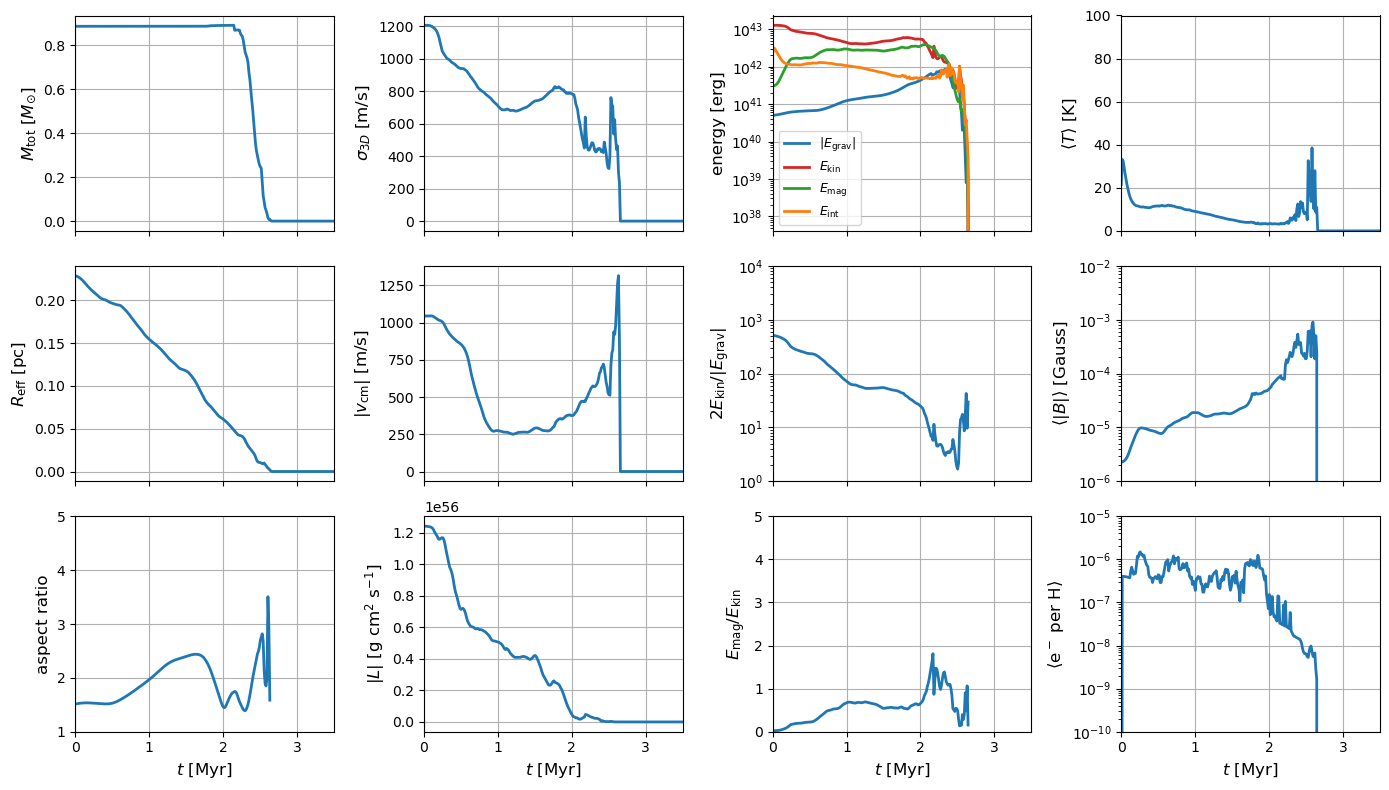

In [16]:
make_fig(sink_IDs[2], savefig=False)